# Weighted CRPS models

In this notebook, we explore the use of weighted Continuous Ranked Probability Score (CRPS) to improve the accuracy of probabilistic forecasts. We will demonstrate how to implement models and apply the weighted CRPS loss function, allowing the model to focus on specific regions of the target distribution. This approach is particularly useful when dealing with skewed or multi-modal distributions, where standard CRPS may not provide optimal results.

# Imports, loading and splitting data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from torchnaut import mdn, utils, kde, crps, epistemic
from torchnaut.utils import LabelScaler

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load dataset
data = load_diabetes()
X, y = data.data, data.target.reshape(-1, 1) # Note: reshape y to 2D.

# Split into train (70%), validation (15%), and test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Preprocessing

In [2]:
# Standardize features using training data only
scaler_X = StandardScaler().fit(X_train)
X_train = scaler_X.transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

# The utils.LabelScaler class provides a convenient way to standardize targets, with the ability to
# also inverse transform tensors of shape [batch_size, n_samples, n_features]
scaler_y = LabelScaler()
y_train_scaled = scaler_y.fit_transform(y_train)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [3]:
# General weighted CRPS Model with multiple sampling heads and sampling layers
class CRPS_Model(nn.Module):
    def __init__(self, input_dim, n_sampling_heads=1, n_sampling_layers=1):
        super().__init__()
        self.n_sampling_heads = n_sampling_heads
        self.n_sampling_layers = n_sampling_layers
        self.layers = nn.ModuleList([
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            crps.EpsilonSampler(16), 
            nn.Linear(64 + 16, 32),
            nn.ReLU(),
        ])
        # Each head of each layer needs to output weight and location
        self.locations = nn.Linear(32, self.n_sampling_layers * n_sampling_heads)
        self.weights = nn.Linear(32, self.n_sampling_layers * n_sampling_heads)

    # set a smaller default number of samples, as this gets multiplied by the number of heads and layers
    def forward(self, x, n_samples=100):
        with crps.EpsilonSampler.n_samples(n_samples):
            for layer in self.layers:
                x = layer(x)

        # locations are initially of shape [batch_size, n_samples, n_sampling_layers * n_sampling_heads]
        locations = self.locations(x)
        # transpose to [batch_size, n_sampling_layers * n_sampling_heads, n_samples]
        locations = locations.transpose(-1, -2)
        # reshape to [batch_size, n_sampling_layers, n_sampling_heads * n_samples] so that the different
        # heads are mixed together as samples, however the loss is applied to each layer separately
        locations = locations.reshape(x.shape[0], self.n_sampling_layers, -1)
        # same for weights
        weights_raw = self.weights(x).transpose(-1, -2).reshape(x.shape[0], self.n_sampling_layers, -1)
        
        # weights are in fact change of measure coefficients, so they need to be normalized to sum
        # to n_sampling_heads * n_samples (size of the last dimension)
        weights_log_softmax = nn.functional.log_softmax(weights_raw, dim=-1)
        weights = torch.exp(weights_log_softmax + np.log(weights_log_softmax.shape[-1]))
        return locations, weights
    
    # methods for templated training and evaluation:

    @staticmethod
    def train_loss(model, batch_X, batch_y):
        with crps.EpsilonSampler.n_samples(max(5, 100 // (model.n_sampling_heads * model.n_sampling_layers)) + 1):
            locations, weights = model(batch_X)
        # outputs are shaped similarly to the ensemble outputs from the previous notebook
        return crps.crps_loss_weighted(locations, weights, batch_y.unsqueeze(-2)).mean()
    
    @staticmethod
    def validation_loss(model, batch_X, batch_y, scaler_y):
        with crps.EpsilonSampler.n_samples(1000 // (model.n_sampling_heads * model.n_sampling_layers) + 1):
            locations, weights = model(batch_X)
        locations_scaled = scaler_y.inverse_transform(locations.unsqueeze(-1)).squeeze(-1)
        # need to be flattened the same way too
        locations_scaled = locations_scaled.flatten(start_dim=-2)
        weights = weights.flatten(start_dim=-2)
        return crps.crps_loss_weighted(locations_scaled, weights, batch_y)

    @staticmethod
    def test_eval(model, batch_X, batch_y, scaler_y):
        with crps.EpsilonSampler.n_samples(10000 // (model.n_sampling_heads * model.n_sampling_layers) + 1):
            locations, weights = model(batch_X)
        locations_scaled = scaler_y.inverse_transform(locations.unsqueeze(-1)).squeeze(-1)
        locations_scaled = locations_scaled.flatten(start_dim=-2)
        weights = weights.flatten(start_dim=-2)

        crps_loss = crps.crps_loss_weighted(locations_scaled, weights, batch_y)
        with torch.device(locations.device):
            nll = kde.nll_gpu_weighted(locations_scaled, weights, batch_y)
        pred_mean = (locations_scaled*weights).sum(dim=-1)/weights.sum(dim=-1)

        return nll, crps_loss, pred_mean

In [4]:
# CRPS Ensemble Model for weighted versions
class CRPS_Ensemble_Model(epistemic.CRPSEnsemble):
    # most of the logic is already implemented in the parent class
    
    # methods for templated training and evaluation:

    @staticmethod
    def train_loss(model, batch_X, batch_y):
        locations, weights = model(batch_X)
        # ensemble outputs of of miltihead/multi-layer models are given as
        # [batch_size x n_ensemble x n_sampling_layers x (n_samples * n_sampling_heads)]
        return crps.crps_loss_weighted(locations, weights, batch_y.unsqueeze(1).unsqueeze(2)).mean()
    
    @staticmethod
    def validation_loss(model, batch_X, batch_y, scaler_y):
        locations, weights = model(batch_X)
        locations_scaled = scaler_y.inverse_transform(locations.unsqueeze(-1)).squeeze()

        # for validation and testing, we need to flatten all dimensions except batch_size, i.e. get
        # [batch_size, n_ensemble * n_sampling_layers * n_samples * n_sampling_heads]
        locations_scaled = locations_scaled.flatten(start_dim=1)
        weights = weights.flatten(start_dim=1)
        return crps.crps_loss_weighted(locations_scaled, weights, batch_y)

    @staticmethod
    def test_eval(model, batch_X, batch_y, scaler_y):
        locations, weights = model(batch_X)
        locations_scaled = scaler_y.inverse_transform(locations.unsqueeze(-1)).squeeze()
        locations_scaled = locations_scaled.flatten(start_dim=1)
        weights = weights.flatten(start_dim=1)

        crps_loss = crps.crps_loss_weighted(locations_scaled, weights, batch_y)
        with torch.device(locations.device):
            nll = kde.nll_gpu_weighted(locations_scaled, weights, batch_y)
        pred_mean = (locations_scaled*weights).sum(dim=-1)/weights.sum(dim=-1)

        return nll, crps_loss, pred_mean

In [6]:
def train(model, lr=0.001, n_samples=100, valid_n_samples=1000):
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, total_iters=5)

    # Training loop with validation
    epochs = 100
    best_val_loss = np.inf
    best_model = None
    patience = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()

            loss = model.train_loss(model, batch_X, batch_y)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)
            optimizer.step()
            train_loss += loss.item()
        scheduler.step()

        # Validation phase
        model.eval()
        val_losses = []
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                val_loss = model.validation_loss(model, batch_X, batch_y, scaler_y)
                val_losses.append(val_loss.cpu().numpy())
            val_loss = np.concatenate(val_losses).mean()

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}")
        if best_val_loss > val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            patience = 0
        else:
            patience += 1
            if patience >= 9:
                print("Early stopping!")
                model.load_state_dict(best_model)
                break

In [10]:
models = {}

models["CRPS Weighted"] = CRPS_Model(input_dim=X_train.shape[1]).to(device)
models["CRPS Weighted Ensemble"] = CRPS_Ensemble_Model(
    [CRPS_Model(input_dim=X_train.shape[1]).to(device) for _ in range(5)],
    concat_dim=1,
).to(device)
models["CRPS Weighted Multihead"] = CRPS_Model(
    input_dim=X_train.shape[1],
    n_sampling_heads=5,
).to(device)
models["CRPS Weighted Multihead-Multilayer"] = CRPS_Model(
    input_dim=X_train.shape[1],
    n_sampling_heads=5,
    n_sampling_layers=3,
).to(device)
models["CRPS Weighted Multihead-Multilayer Ensemble"] = CRPS_Ensemble_Model(
    [CRPS_Model(input_dim=X_train.shape[1], n_sampling_heads=5, n_sampling_layers=3).to(device) for _ in range(5)],
    concat_dim=1,
).to(device)

In [11]:
for name, model in models.items():
    train(model, lr=0.0001)

Epoch [1/100], Train Loss: 0.8329, Val Loss: 59.6130
Epoch [2/100], Train Loss: 0.8148, Val Loss: 59.1888
Epoch [3/100], Train Loss: 0.7954, Val Loss: 58.3373
Epoch [4/100], Train Loss: 0.8043, Val Loss: 57.2783
Epoch [5/100], Train Loss: 0.7856, Val Loss: 55.8100
Epoch [6/100], Train Loss: 0.7619, Val Loss: 54.1749
Epoch [7/100], Train Loss: 0.7569, Val Loss: 52.2454
Epoch [8/100], Train Loss: 0.7249, Val Loss: 50.1228
Epoch [9/100], Train Loss: 0.7129, Val Loss: 48.2674
Epoch [10/100], Train Loss: 0.6885, Val Loss: 46.0278
Epoch [11/100], Train Loss: 0.6763, Val Loss: 43.7384
Epoch [12/100], Train Loss: 0.6353, Val Loss: 41.4499
Epoch [13/100], Train Loss: 0.6208, Val Loss: 38.9274
Epoch [14/100], Train Loss: 0.5907, Val Loss: 36.5655
Epoch [15/100], Train Loss: 0.5646, Val Loss: 33.9885
Epoch [16/100], Train Loss: 0.5422, Val Loss: 32.0499
Epoch [17/100], Train Loss: 0.5080, Val Loss: 30.3049
Epoch [18/100], Train Loss: 0.4871, Val Loss: 28.9435
Epoch [19/100], Train Loss: 0.4823, V

In [12]:
for name, model in models.items():
    test_crps = []
    test_rmse = []
    test_nll = []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            nll, crps_loss, pred_mean = model.test_eval(model, batch_X.to(device), batch_y.to(device), scaler_y)
            test_crps.append(crps_loss.cpu().numpy())
            test_nll.append(nll.cpu().numpy())
            test_rmse.append(((batch_y - pred_mean.cpu().numpy()) ** 2).mean(dim=-1).cpu().numpy())
        test_crps = np.concatenate(test_crps).mean()
        test_nll = np.concatenate(test_nll).mean()
        test_rmse = np.sqrt(np.concatenate(test_rmse).mean())

    print(f"{name} Test CRPS: {test_crps:.4f}")
    print(f"{name} Test NLL: {test_nll:.4f}")
    print(f"{name} Test RMSE: {test_rmse:.4f}")

CRPS Weighted Test CRPS: 32.1572
CRPS Weighted Test NLL: 5.4130
CRPS Weighted Test RMSE: 86.5887
CRPS Weighted Ensemble Test CRPS: 30.8795
CRPS Weighted Ensemble Test NLL: 5.3957
CRPS Weighted Ensemble Test RMSE: 85.8299
CRPS Weighted Multihead Test CRPS: 32.1319
CRPS Weighted Multihead Test NLL: 5.4029
CRPS Weighted Multihead Test RMSE: 84.9669
CRPS Weighted Multihead-Multilayer Test CRPS: 31.5787
CRPS Weighted Multihead-Multilayer Test NLL: 5.4186
CRPS Weighted Multihead-Multilayer Test RMSE: 84.2762
CRPS Weighted Multihead-Multilayer Ensemble Test CRPS: 31.3753
CRPS Weighted Multihead-Multilayer Ensemble Test NLL: 5.4067
CRPS Weighted Multihead-Multilayer Ensemble Test RMSE: 84.4780


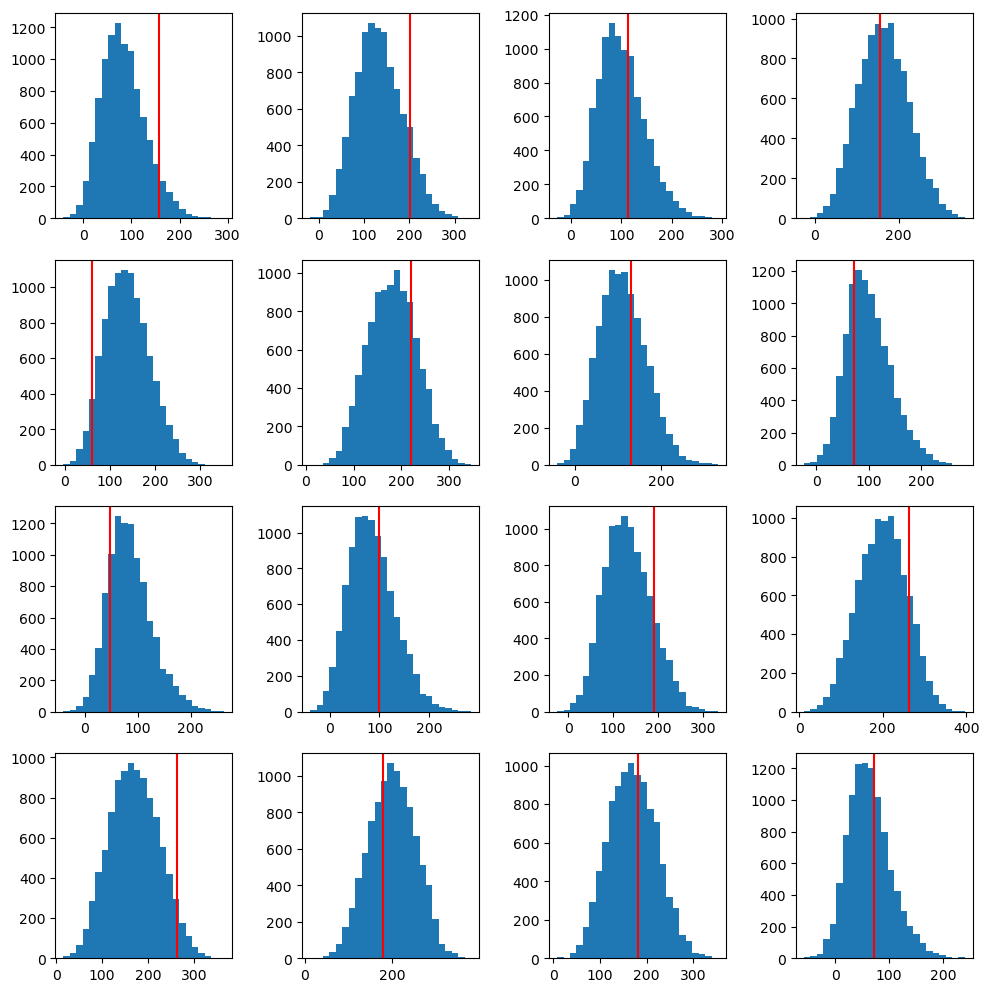

In [13]:
model = models["CRPS Weighted"]

# Predictions for the first batch of the test set
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        with crps.EpsilonSampler.n_samples(10000 // (model.n_sampling_heads * model.n_sampling_layers) + 1):
            locations, weights = model(batch_X)  # both have shape (batch_size, n_samples)
        locations, weights = locations.cpu(), weights.cpu()
        # Apply inverse scaling to the locations. Adjust dimensions as needed.
        locations_scaled = scaler_y.inverse_transform(locations.unsqueeze(-1)).squeeze(-1)
        locations_scaled = locations_scaled.flatten(start_dim=-2)
        weights = weights.flatten(start_dim=-2)
        break

fig, _ = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i, (preds, w, y) in enumerate(zip(locations_scaled, weights, batch_y)):
    plt.subplot(4, 4, i+1)
    # Use the corresponding weights for the i-th sample.
    plt.hist(
        preds.numpy(), 
        bins=25, 
        weights=w.numpy()  # the weights are applied here
    )
    plt.axvline(y, color="red")
plt.tight_layout()  # optional: adjust subplot spacing
plt.show()

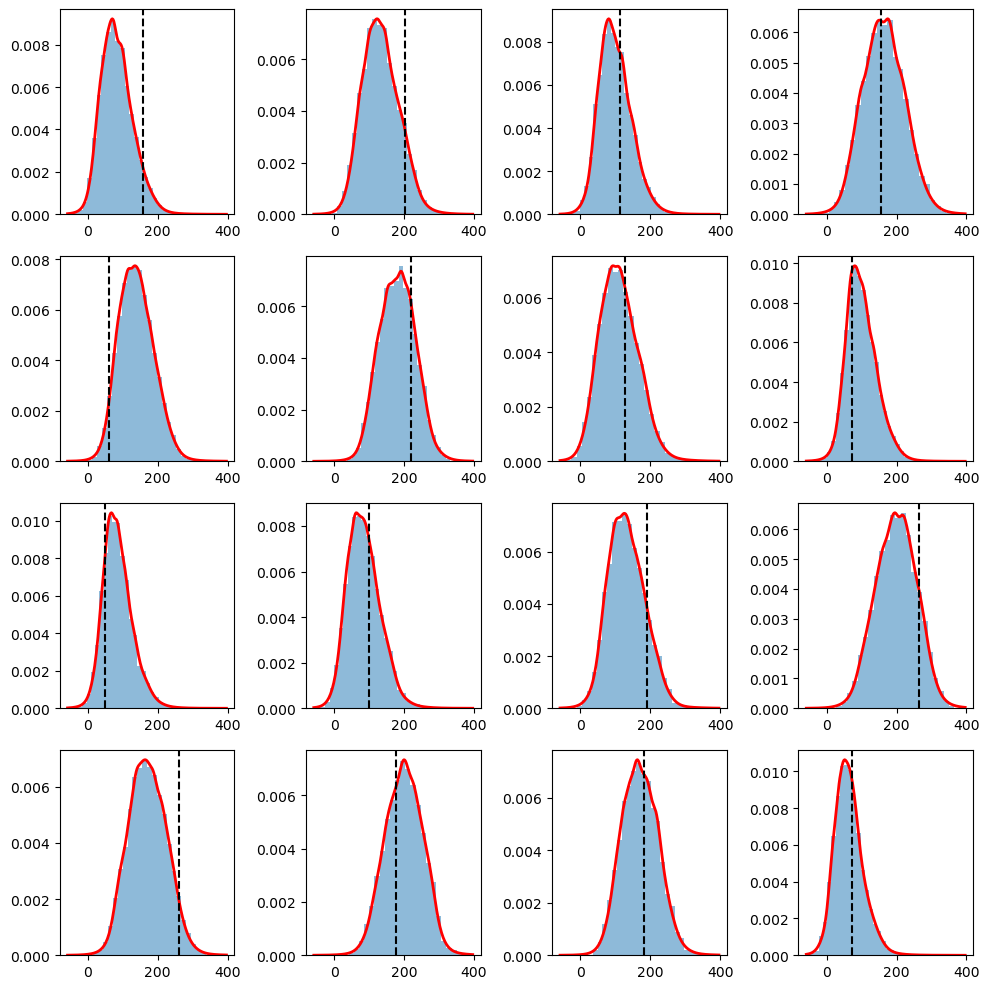

In [14]:
# Get weighted KDE distributions. Returns a list of PyTorch MixtureSameFamily distributions.
kde_dists = kde.get_kde(locations_scaled, weights)

# Create evaluation points for density plotting
x_range = np.linspace(locations_scaled.min().item(), locations_scaled.max().item(), 200)
x_eval = torch.tensor(x_range).float()

fig, _ = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i, (preds, w, y, dist) in enumerate(zip(locations_scaled, weights, batch_y, kde_dists)):
    plt.subplot(4, 4, i+1)
    # Plot weighted histogram of samples
    plt.hist(preds.cpu().numpy(), weights=w.numpy(), bins=25, density=True, alpha=0.5)
    # Plot KDE
    density = torch.exp(dist.log_prob(x_eval))
    plt.plot(x_range, density.cpu().numpy(), 'r-', lw=2)
    plt.axvline(y, color="black", linestyle='--')
plt.tight_layout()

In [15]:
model.eval()
all_locations = []
all_weights = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        with crps.EpsilonSampler.n_samples(10000):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        locations, weights = model(batch_X)
        locations_scaled = scaler_y.inverse_transform(locations.unsqueeze(-1)).squeeze(-1)
        locations_scaled = locations_scaled.flatten(start_dim=-2)
        weights = weights.flatten(start_dim=-2)

        all_locations.append(locations_scaled.cpu().numpy())
        all_weights.append(weights.cpu().numpy())

    all_locations = np.concatenate(all_locations, axis=0)
    all_weights = np.concatenate(all_weights, axis=0)

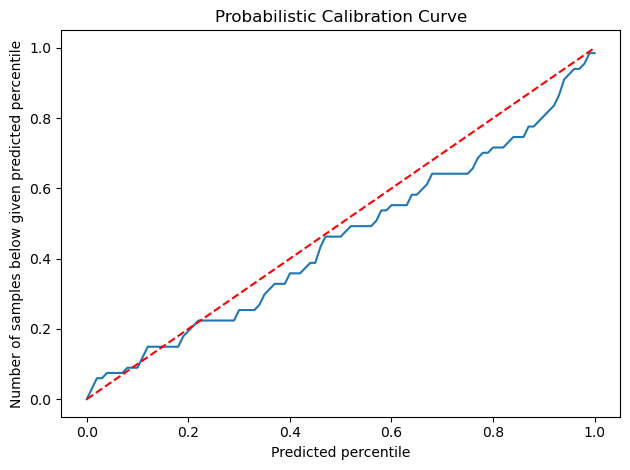

In [16]:
ref_percentiles, cumulative_percentiles = utils.calculate_pit_cdf(
    all_locations,
    y_test,
    weights=all_weights,
)

# Plot probabilistic calibration curve (PIT CDF) against the reference line
plt.title("Probabilistic Calibration Curve")
plt.plot(ref_percentiles, cumulative_percentiles)
plt.plot(ref_percentiles, ref_percentiles, c="r", linestyle='--')
plt.ylabel("Number of samples below given predicted percentile")
plt.xlabel("Predicted percentile")
plt.tight_layout()